# Finite Markov Chains: Examples

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

This notebook demonstrates how to analyze finite-state Markov chains
with the `MarkovChain` class.
For basic concepts and properties on Markov chains, see

* [the lecture on finite Markov chains](https://lectures.quantecon.org/py/finite_markov.html)
  in Quantitative Economics, and
* [the documentation for `MarkovChain`](http://quanteconpy.readthedocs.org/en/stable/markov/core.html).

For algorithmic issues in detecting reducibility and periodicity of a Markov chain,
see, for example,

* J. P. Jarvis and D. R. Shier,
  "[Graph-Theoretic Analysis of Finite Markov Chains](http://www.ces.clemson.edu/~shierd/Shier/markov.pdf),"

from which we draw some examples below.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon.markov import MarkovChain

## Example 1: Reducible chain

Consider the Markov chain given by the following stochastic matrix,
taken from Exercise 3 in Jarvis and Shier
(where the actual values of non-zero probabilities are not important):

In [3]:
P = np.zeros((6, 6))
P[0, 0] = 1
P[1, 4] = 1
P[2, [2, 3, 4]] = 1/3
P[3, [0, 5]] = 1/2
P[4, [1, 4]] = 1/2
P[5, [0, 3]] = 1/2

In [4]:
print(P)

[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.5        0.         0.         0.         0.         0.5       ]
 [0.         0.5        0.         0.         0.5        0.        ]
 [0.5        0.         0.         0.5        0.         0.        ]]


Create a MarkovChain instance:

In [5]:
mc1 = MarkovChain(P)

### Classification of states

This Markov chain is reducible:

In [6]:
mc1.is_irreducible

False

In [7]:
mc1.num_communication_classes

4

Determine the communication classes:

In [8]:
mc1.communication_classes

[array([0]), array([1, 4]), array([3, 5]), array([2])]

Classify the states of this Markov chain:

In [9]:
mc1.recurrent_classes

[array([0]), array([1, 4])]

Obtain a list of the recurrent states:

In [10]:
recurrent_states = np.concatenate(mc1.recurrent_classes)
print(recurrent_states)

[0 1 4]


Obtain a list of the transient states:

In [11]:
transient_states = np.setdiff1d(np.arange(mc1.n), recurrent_states)
print(transient_states)

[2 3 5]


A Markov chain is reducible (i.e., its directed graph is not strongly connected)
if and only if by symmetric permulations of rows and columns,
its transition probability matrix is written in the form ("canonical form")
$$
\begin{pmatrix}
U & 0 \\
W & V
\end{pmatrix},
$$
where $U$ and $W$ are square matrices.

Such a form for `mc1` is obtained by the following:

In [12]:
permutation = np.concatenate([recurrent_states, transient_states])
print(mc1.P[np.ix_(permutation, permutation)])

[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.5        0.5        0.         0.         0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.5        0.         0.         0.         0.         0.5       ]
 [0.5        0.         0.         0.         0.5        0.        ]]


This Markov chain is aperiodic
(i.e., the least common multiple of the periods of the recurrent sub-chains is one):

In [13]:
mc1.is_aperiodic

True

Indeed, each of the sub-chains corresponding to the recurrent classes has period $1$,
i.e., every recurrent state is aperiodic:

In [14]:
for recurrent_class in mc1.recurrent_classes:
    sub_matrix = P[np.ix_(recurrent_class, recurrent_class)]
    d = MarkovChain(sub_matrix).period
    print('Period of the sub-chain\n{0}\n = {1}'.format(sub_matrix, d))

Period of the sub-chain
[[1.]]
 = 1
Period of the sub-chain
[[0.  1. ]
 [0.5 0.5]]
 = 1


### Stationary distributions

For each recurrent class $C$, there is a unique stationary distribution $\psi^C$
such that $\psi^C_i > 0$ for all $i \in C$ and $\psi^C_i = 0$ otherwise.
`MarkovChain.stationary_distributions` returns
these unique stationary distributions for the recurrent classes.
Any stationary distribution is written as a convex combination of these distributions.

In [15]:
print(mc1.stationary_distributions)

[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.         0.66666667 0.        ]]


These are indeed stationary distributions:

In [16]:
print(mc1.stationary_distributions.dot(mc1.P))

[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.         0.66666667 0.        ]]


Plot these distributions.

In [17]:
def draw_histogram(distribution, ax=None, figsize=None,
                   title=None, xlabel=None, ylabel=None, ylim=(0, 1)):
    """
    Plot the given distribution.
    
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    n = len(distribution)
    ax.bar(np.arange(n), distribution, align='center')
    ax.set_xlim(-0.5, (n-1)+0.5)
    ax.set_ylim(*ylim)
    ax.set_xticks(range(n))
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if ax is None:
        plt.show()

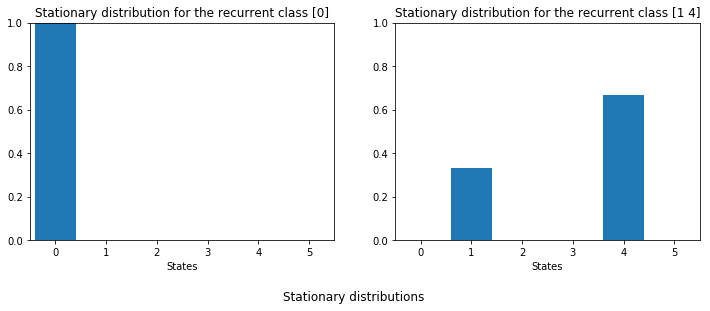

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
titles = ['Stationary distribution for the recurrent class {0}'.format(recurrent_class)
          for recurrent_class in mc1.recurrent_classes]

for ax, title, dist in zip(axes, titles, mc1.stationary_distributions):
    draw_histogram(dist, ax=ax, title=title, xlabel='States')

fig.suptitle('Stationary distributions', y=-0.05, fontsize=12)
plt.show()

### Simulation

Let us simulate our Markov chain `mc1`.
The `simualte` method generates a sample path
of length given by the first argument, `ts_length`,
with an initial state as specified by an optional argument `init`;
if not specified, the initial state is randomly drawn. 

A sample path from state `0`:

In [19]:
mc1.simulate(50, init=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

As is clear from the transition matrix `P`,
if it starts at state `0`, the chain stays there forever,
i.e., `0` is an absorbing state, a state that constitutes a singleton recurrent class.

Start with state `1`:

In [20]:
mc1.simulate(50, init=1)

array([1, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 4, 4, 1,
       4, 1, 4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 1,
       4, 1, 4, 1, 4, 1])

You can observe that the chain stays in the recurrent class $\{1,4\}$
and visits states `1` and `4` with certain frequencies.

If `init` is not specified, the initial state is randomly chosen:

In [21]:
mc1.simulate(50)

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

**Note on reproducibility**:
The `simulate` method offers an option `random_state` to set a random seed
to initialize the pseudo-random number generator.
As you provide the same random seed value,
`simulate` returns the same outcome.

For example, the following will always give the same sequence:

In [22]:
mc1.simulate(50, random_state=12345)

array([2, 4, 1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4,
       4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4,
       1, 4, 4, 4, 4, 4])

#### Time series averages

Now, let us compute the frequency distribution along a sample path, given by
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\}
\quad (s \in S).
$$

In [23]:
def time_series_dist(mc, t, init=None, random_state=None):
    """
    Return the distribution of visits by a sample path of length t
    of mc with an initial state init.
    
    """
    t_max = np.max(t)
    dim = 1
    try:
        ts_size = len(t)  # t is an array
        ts_array = t
        dim = 2
    except:  # t is an int
        ts_size = 1
        ts_array = [t]
        
    X = mc.simulate(ts_length=t_max, init=init, random_state=random_state)
    dists = np.empty((ts_size, mc.n))
    bins = np.arange(mc.n+1)
    for i, length in enumerate(ts_array):
        hist, bin_edges = np.histogram(X[:length], bins=bins)
        dists[i, :] = hist / length
    if dim == 1:
        return dists[0]
    else:
        return dists

Here is a frequency distribution along a sample path,  of length 100,
from initial state `1`, which is a recurrent state:

In [24]:
time_series_dist(mc1, t=100, init=1)

array([0.  , 0.35, 0.  , 0.  , 0.65, 0.  ])

Length 10,000:

In [25]:
time_series_dist(mc1, t=10**4, init=1)

array([0.   , 0.332, 0.   , 0.   , 0.668, 0.   ])

The distribution becomes close to the stationary distribution `(0, 1/3, 0, 0, 2/3, 0)`.

Plot the frequency distributions for a couple of different time lengths:

In [26]:
def plot_time_series_dists(mc, init, ts, seed=None, figsize=(12,4)):
    dists = time_series_dist(mc, t=ts, init=init, random_state=seed)

    fig, axes = plt.subplots(1, len(ts), figsize=figsize)
    titles = ['t={0}'.format(t) for t in ts]

    for ax, title, dist in zip(axes, titles, dists):
        draw_histogram(dist, ax=ax, title=title, xlabel='States')

    fig.suptitle('Time series distributions with init={0}'.format(init),
                 y=-0.05, fontsize=12)
    plt.show()

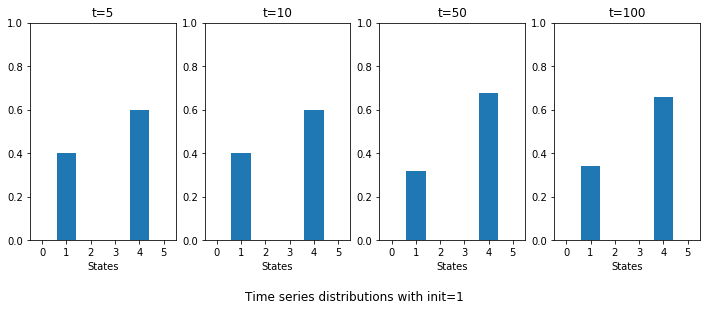

In [27]:
init = 1
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, init, ts)

Start with state `2`,
which is a transient state:

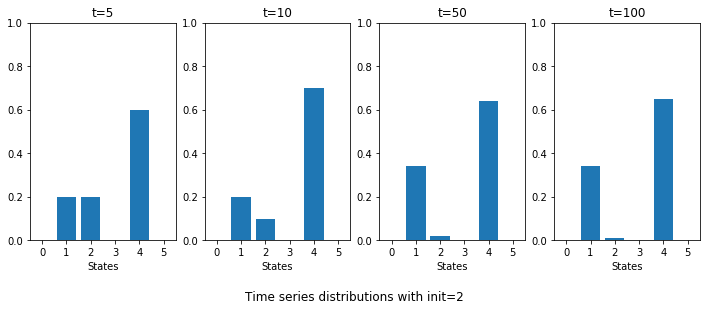

In [28]:
init = 2
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, init, ts)

Run the above cell several times;
you will observe that the limit distribution differs across sample paths.
Sometimes the state is absorbed into the recurrent class $\{0\}$,
while other times it is absorbed into the recurrent class $\{1,4\}$.

Some sample path with init=2


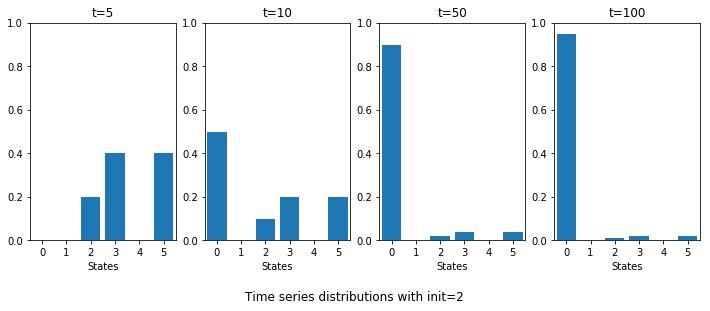

Another sample path with init=2


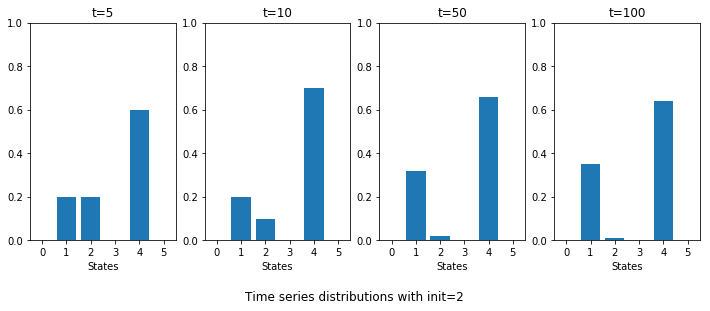

In [29]:
init = 2
ts = [5, 10, 50, 100]
seeds = [222, 2222]
descriptions = ['{0} sample path with init={1}'.format(adjective, init) for adjective
                in ['Some'] + ['Another'] + ['Yet another']*(len(seeds)-1)]

for seed, description in zip(seeds, descriptions):
    print(description)
    plot_time_series_dists(mc1, init, ts, seed=seed)

In fact,
for almost every sample path of a finite Markov chain $\{X_t\}$,
for some recurrent class $C$ we have
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\} \to \psi^C[s]
\quad \text{as $t \to \infty$}
$$
for all states $s$,
where $\psi^C$ is the stationary distribution associated with the recurrent class $C$.

If the initial state $s_0$ is a recurrent state,
then the recurrent class $C$ above is the one that contains $s_0$,
while if it is a transient state,
then the recurrent class to which the convergence occurs depends on the sample path.

Let us simulate with the remaining states, `3`, `4`, and `5`.

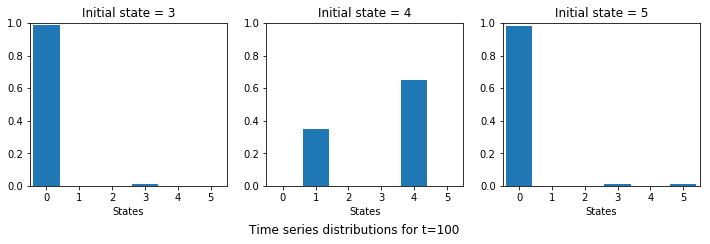

In [30]:
inits = [3, 4, 5]
t = 100

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for init, ax in zip(inits, axes):
    draw_histogram(time_series_dist(mc1, t=t, init=init), ax=ax,
                   title='Initial state = {0}'.format(init),
                   xlabel='States')

fig.suptitle('Time series distributions for t={0}'.format(t),
             y=-0.05, fontsize=12)
plt.show()

#### Cross sectional averages

Next, let us repeat the simulation for many times (say, 10,000 times)
and obtain the distribution of visits to each state at a given time period `T`.
That is, we want to simulate the marginal distribution at time `T`.

In [31]:
def cross_sectional_dist(mc, T, init=None, num_reps=10**4, random_state=None):
    """
    Return the distribution of visits at time T by num_reps times of simulation
    of mc with an initial state init.
    
    """
    T_max = np.max(T)
    dim = 1
    try:
        Ts_size = len(T)  # T is an array
        Ts_array = T
        dim = 2
    except:  # T is an int
        Ts_size = 1
        Ts_array = [T]
    
    x = mc.simulate(ts_length=T_max+1, init=init, num_reps=num_reps,
                    random_state=random_state)[:, Ts_array]
    dists = np.empty((x.shape[-1], mc.n))
    bins = np.arange(mc.n+1)
    for i in range(x.shape[-1]):
        hist, bin_edges = np.histogram(x[:, i], bins=bins)
        dists[i, :] = hist / num_reps
    if dim == 1:
        return dists[0]
    else:
        return dists

Start with state `1`:

In [32]:
init = 1
T = 10
cross_sectional_dist(mc1, init=init, T=T)

array([0.    , 0.3352, 0.    , 0.    , 0.6648, 0.    ])

In [33]:
T = 100
cross_sectional_dist(mc1, init=init, T=T)

array([0.    , 0.3312, 0.    , 0.    , 0.6688, 0.    ])

The distribution is close to the stationary distribution `(0, 1/3, 0, 0, 2/3, 0)`.

Plot the simulated marginal distribution at `T` for some values of `T`.

In [34]:
def plot_cross_sectional_dists(mc, init, Ts, num_reps=10**4, seed=None,
                               figsize=(12,4)):
    dists = cross_sectional_dist(mc, T=Ts, init=init, num_reps=num_reps,
                                 random_state=seed)

    fig, axes = plt.subplots(1, len(Ts), figsize=figsize)
    titles = ['T={0}'.format(T) for T in Ts]

    for ax, title, dist in zip(axes, titles, dists):
        draw_histogram(dist, ax=ax, title=title, xlabel='States')

    fig.suptitle('Cross sectional distributions with init={0}'.format(init),
                 y=-0.05, fontsize=12)
    plt.show()

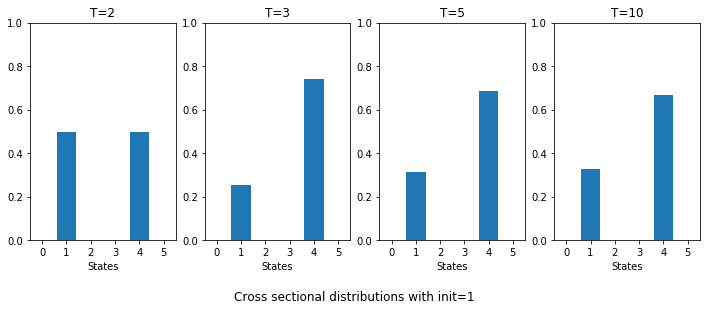

In [35]:
init = 1
Ts = [2, 3, 5, 10]
plot_cross_sectional_dists(mc1, init, Ts)

Starting with a transient state `2`:

In [36]:
init = 2
T = 10
cross_sectional_dist(mc1, init=init, T=T)

array([0.502 , 0.1641, 0.    , 0.0007, 0.3318, 0.0014])

In [37]:
T = 100
dist = cross_sectional_dist(mc1, init=init, T=T)
dist

array([0.4962, 0.1691, 0.    , 0.    , 0.3347, 0.    ])

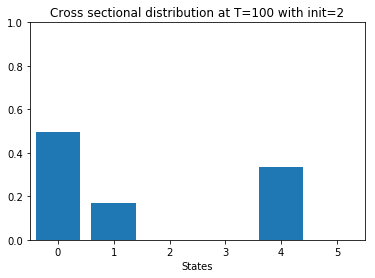

In [38]:
draw_histogram(dist,
               title='Cross sectional distribution at T={T} with init={init}'
                     .format(T=T, init=init),
               xlabel='States')

Observe that the distribution is close to a convex combination of
the stationary distributions `(1, 0, 0, 0, 0, 0)` and `(0, 1/3, 0, 0, 2/3, 0)`,
which is a stationary distribution itself.

How the simulated marginal distribution evolves:

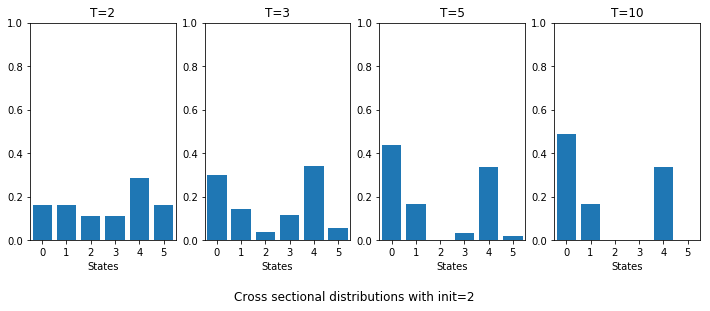

In [39]:
init = 2
Ts = [2, 3, 5, 10]
plot_cross_sectional_dists(mc1, init, Ts)

Since our Markov chain is aperiodic (i.e., every recurrent class is aperiodic),
the marginal disribution at time $T$ converges as $T \to \infty$
to some stationary distribution,
and the limit distribution depends on the initial state,
according to the probabilities that the state is absorbed into the recurrent classes.

For initial states `3`, `4`, and `5`:

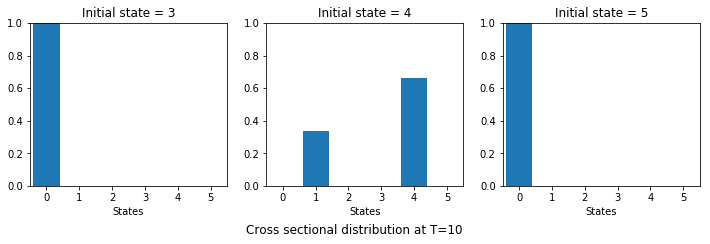

In [40]:
inits = [3, 4, 5]
T = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for init, ax in zip(inits, axes):
    draw_histogram(cross_sectional_dist(mc1, T=T, init=init), ax=ax,
                   title='Initial state = {0}'.format(init),
                   xlabel='States')

fig.suptitle('Cross sectional distribution at T={0}'.format(T),
             y=-0.05, fontsize=12)
plt.show()

### Powers of $P$

The marginal distributions at time $T$ are obtained by $P^T$.

In [41]:
np.set_printoptions(suppress=True)  # Suppress printing with floating point notation

In [42]:
Ts = [10, 20, 30]
for T in Ts:
    print('P^{T} =\n{P_T}'.format(T=T, P_T=np.linalg.matrix_power(mc1.P, T)))

P^10 =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33398438 0.         0.         0.66601562 0.        ]
 [0.49807228 0.16679179 0.00001694 0.0007677  0.33319974 0.00115155]
 [0.99902344 0.         0.         0.00097656 0.         0.        ]
 [0.         0.33300781 0.         0.         0.66699219 0.        ]
 [0.99902344 0.         0.         0.         0.         0.00097656]]
P^20 =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33333397 0.         0.         0.66666603 0.        ]
 [0.49999809 0.16666679 0.         0.00000076 0.33333321 0.00000114]
 [0.99999905 0.         0.         0.00000095 0.         0.        ]
 [0.         0.33333302 0.         0.         0.66666698 0.        ]
 [0.99999905 0.         0.         0.         0.         0.00000095]]
P^30 =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.         0.66666667 0.        ]
 [0.5      

In the canonical form:

In [43]:
Q = mc1.P[np.ix_(permutation, permutation)]
print('Q =\n{Q}'.format(Q=Q))
for T in Ts:
    print('Q^{T} =\n{Q_T}'.format(T=T, Q_T=np.linalg.matrix_power(Q, T)))

Q =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.5        0.5        0.         0.         0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.5        0.         0.         0.         0.         0.5       ]
 [0.5        0.         0.         0.         0.5        0.        ]]
Q^10 =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33398438 0.66601562 0.         0.         0.        ]
 [0.         0.33300781 0.66699219 0.         0.         0.        ]
 [0.49807228 0.16679179 0.33319974 0.00001694 0.0007677  0.00115155]
 [0.99902344 0.         0.         0.         0.00097656 0.        ]
 [0.99902344 0.         0.         0.         0.         0.00097656]]
Q^20 =
[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.33333397 0.66666603 0.         0.         0.        ]
 [0.         0

Observe that the first three rows, which correspond to the recurrent states,
are close to the stationary distributions associated with the corresponding recurrent classes.

## Example 2: Periodic chain

Consider the Markov chain given by the following stochastic matrix,
taken from Exercise 9 (see also Exercise 11) in Jarvis and Shier
(where the actual values of non-zero probabilities are not important):

In [44]:
P = np.zeros((10, 10))
P[0, 3] = 1
P[1, [0, 4]] = 1/2
P[2, 6] = 1
P[3, [1, 2, 7]] = 1/3
P[4, 3] = 1
P[5, 4] = 1
P[6, 3] = 1
P[7, [6, 8]] = 1/2
P[8, 9] = 1
P[9, 5] = 1

In [45]:
np.set_printoptions(precision=3)  # Reduce the number of digits printed
print(P)

[[0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.5   0.    0.    0.    0.5   0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.333 0.333 0.    0.    0.    0.    0.333 0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.5   0.    0.5   0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]]


In [46]:
mc2 = MarkovChain(P)

This Markov chain is irreducible:

In [47]:
mc2.is_irreducible

True

This Markov chain is periodic:

In [48]:
mc2.is_aperiodic

False

Its period, which we denote by $d$:

In [49]:
d = mc2.period
print(d)

3


Identify the cyclic classes:

In [50]:
mc2.cyclic_classes

[array([0, 4, 6, 8]), array([3, 9]), array([1, 2, 5, 7])]

### Cyclic normal form

If a Markov chain is periodic with period $d \geq 2$,
then its transition probability matrix is written in the form ("cyclic normal form")
$$
\begin{pmatrix}
0       & P_0    & 0      & 0      & \cdots & 0 \\
0       & 0      & P_1    & 0      & \cdots & 0 \\
0       & 0      & 0      & P_2    & \cdots & 0 \\
\vdots  & \vdots & \vdots & \vdots & \ddots & \vdots \\
0       & 0      & 0      & 0      & \cdots & P_{d-2} \\
P_{d-1} & 0      & 0      & 0      & \cdots & 0
\end{pmatrix}.
$$

Represent our Markov chain in cyclic normal form:

In [51]:
permutation = np.concatenate(mc2.cyclic_classes)
Q = mc2.P[np.ix_(permutation, permutation)]
print(Q)

[[0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.5   0.5   0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.5   0.5   0.    0.    0.    0.    0.    0.   ]]


Re-define the Markov chain with the above matrix `Q`:

In [52]:
mc2 = MarkovChain(Q)

Obtain the block components $P_0, \cdots, P_{d-1}$:

In [53]:
P_blocks = []

for i in range(d):
    P_blocks.append(mc2.P[np.ix_(mc2.cyclic_classes[i%d], mc2.cyclic_classes[(i+1)%d])])
    print('P_{i} =\n{P_block}'.format(i=i, P_block=P_blocks[i]))

P_0 =
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
P_1 =
[[0.333 0.333 0.    0.333]
 [0.    0.    1.    0.   ]]
P_2 =
[[0.5 0.5 0.  0. ]
 [0.  0.  1.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]]


$P^d$ is block diagonal:

In [54]:
P_power_d = np.linalg.matrix_power(mc2.P, d)
print(P_power_d)

[[0.167 0.167 0.5   0.167 0.    0.    0.    0.    0.    0.   ]
 [0.167 0.167 0.5   0.167 0.    0.    0.    0.    0.    0.   ]
 [0.167 0.167 0.5   0.167 0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.833 0.167 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.167 0.167 0.5   0.167]]


In [55]:
P_power_d_blocks = []
ordinals = ['0th', '1st', '2nd']

for i in range(d):
    P_power_d_blocks.append(P_power_d[np.ix_(mc2.cyclic_classes[i], mc2.cyclic_classes[i])])
    print('{ordinal} diagonal block of P^d =\n{P_power_d_block}'
          .format(ordinal=ordinals[i], P_power_d_block=P_power_d_blocks[i]))

0th diagonal block of P^d =
[[0.167 0.167 0.5   0.167]
 [0.167 0.167 0.5   0.167]
 [0.167 0.167 0.5   0.167]
 [0.    1.    0.    0.   ]]
1st diagonal block of P^d =
[[0.833 0.167]
 [1.    0.   ]]
2nd diagonal block of P^d =
[[0.333 0.333 0.    0.333]
 [0.333 0.333 0.    0.333]
 [0.333 0.333 0.    0.333]
 [0.167 0.167 0.5   0.167]]


The $i$th diagonal block of $P^d$ equals $P_i P_{i+1} \cdots P_{d-1} P_0 \cdots P_{i-1}$:

In [56]:
products = []

for i in range(d):
    R = np.eye(P_blocks[i].shape[0])
    string = ''
    for j in range(d):
        R = R.dot(P_blocks[(i+j)%d])
        string += 'P_{0} '.format((i+j)%d)
    products.append(R)
    print(string + '=\n{R}'.format(R=R))

P_0 P_1 P_2 =
[[0.167 0.167 0.5   0.167]
 [0.167 0.167 0.5   0.167]
 [0.167 0.167 0.5   0.167]
 [0.    1.    0.    0.   ]]
P_1 P_2 P_0 =
[[0.833 0.167]
 [1.    0.   ]]
P_2 P_0 P_1 =
[[0.333 0.333 0.    0.333]
 [0.333 0.333 0.    0.333]
 [0.333 0.333 0.    0.333]
 [0.167 0.167 0.5   0.167]]


In [57]:
for matrix0, matrix1 in zip(P_power_d_blocks, products):
    print(np.array_equal(matrix0, matrix1))

True
True
True


### Stationary distributions

The Markov chain `mc2` has a unique stationary distribution,
which we denote by $\pi$:

In [58]:
len(mc2.stationary_distributions)

1

In [59]:
pi = mc2.stationary_distributions[0]
print(pi)

[0.048 0.095 0.143 0.048 0.286 0.048 0.095 0.095 0.048 0.095]


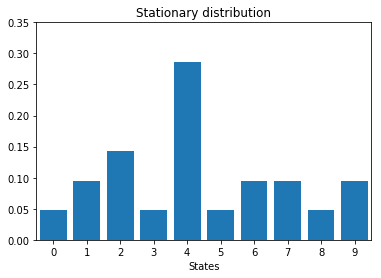

In [60]:
draw_histogram(pi,
               title='Stationary distribution', xlabel='States', ylim=(0, 0.35))

Obtain the stationary distributions $\pi^0, \ldots, \pi^{d-1}$
each associated with the diagonal blocks of $P^d$:

In [61]:
pi_s = []

for i in range(d):
    pi_s.append(MarkovChain(P_power_d_blocks[i]).stationary_distributions[0])
    print('pi^{i} =\n{pi_i}'.format(i=i, pi_i=pi_s[i]))

pi^0 =
[0.143 0.286 0.429 0.143]
pi^1 =
[0.857 0.143]
pi^2 =
[0.286 0.286 0.143 0.286]


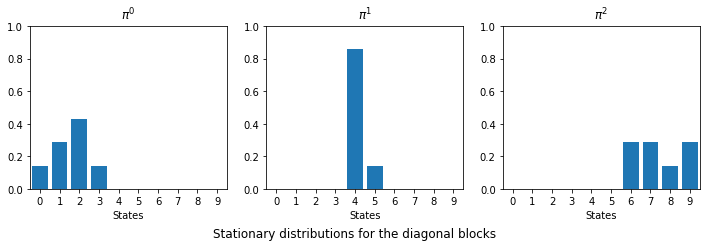

In [62]:
fig, axes = plt.subplots(1, d, figsize=(12, 3))

for i, ax in enumerate(axes):
    pi_i_full_dim = np.zeros(mc2.n)
    pi_i_full_dim[mc2.cyclic_classes[i]] = pi_s[i]
    draw_histogram(pi_i_full_dim,
                   ax=ax, title='$\pi^{i}$'.format(i=i), xlabel='States')

fig.suptitle('Stationary distributions for the diagonal blocks',
             y=-0.05, fontsize=12)
plt.show()

Verify that $\pi^{i+1} = \pi^i P_i$:

In [63]:
for i in range(d):
    print('pi^{i} P_{i} =\n{dot}'.format(i=i, dot=np.dot(pi_s[i], P_blocks[i])))

pi^0 P_0 =
[0.857 0.143]
pi^1 P_1 =
[0.286 0.286 0.143 0.286]
pi^2 P_2 =
[0.143 0.286 0.429 0.143]


Verify that $\pi = (\pi^0 + \cdots + \pi^{d-1})/d$:

In [64]:
# Right hand side of the above identity
rhs = np.zeros(mc2.n)

for i in range(d):
    rhs[mc2.cyclic_classes[i]] = pi_s[i]
rhs /= d
print(rhs)

[0.048 0.095 0.143 0.048 0.286 0.048 0.095 0.095 0.048 0.095]


In [65]:
np.allclose(pi, rhs)

True

### Powers of $P$

Since the Markov chain in consideration is periodic,
the marginal distribution does not converge, but changes periodically.

Let us compute the powers of the transition probability matrix (in cyclic normal form):

In [66]:
np.set_printoptions(suppress=True)  # Suppress printing with floating point notation

Print $P^1, P^2, \ldots, P^d$:

In [67]:
for i in range(1, d+1):
    print('P^{i} =\n{P_i}'.format(i=i, P_i=np.linalg.matrix_power(mc2.P, i)))

P^1 =
[[0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.5   0.5   0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.5   0.5   0.    0.    0.    0.    0.    0.   ]]
P^2 =
[[0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.333 0.333 0.    0.333]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.167 0.167 0.5   0.167 0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.  

Print $P^{2d}$, $P^{4d}$, and $P^{6d}$:

In [68]:
for i in [k*d for k in [2, 4, 6]]:
    print('P^{i} =\n{P_i}'.format(i=i, P_i=np.linalg.matrix_power(mc2.P, i)))

P^6 =
[[0.139 0.306 0.417 0.139 0.    0.    0.    0.    0.    0.   ]
 [0.139 0.306 0.417 0.139 0.    0.    0.    0.    0.    0.   ]
 [0.139 0.306 0.417 0.139 0.    0.    0.    0.    0.    0.   ]
 [0.167 0.167 0.5   0.167 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.861 0.139 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.833 0.167 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.278 0.278 0.167 0.278]
 [0.    0.    0.    0.    0.    0.    0.278 0.278 0.167 0.278]
 [0.    0.    0.    0.    0.    0.    0.278 0.278 0.167 0.278]
 [0.    0.    0.    0.    0.    0.    0.306 0.306 0.083 0.306]]
P^12 =
[[0.143 0.286 0.428 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.428 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.428 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.144 0.282 0.431 0.144 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.857 0.143 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.856 0.144 0. 

$P^{kd}$ converges as $k \to \infty$ to a matrix that contains $\pi^0, \ldots, \pi^{d-1}$.

Print $P^{kd+1}, \ldots, P^{kd+d}$ with $k = 10$ for example:

In [69]:
for i in range(10*d+1, 10*d+1+d):
    print('P^{i} =\n{P_i}'.format(i=i, P_i=np.linalg.matrix_power(mc2.P, i)))

P^31 =
[[0.    0.    0.    0.    0.857 0.143 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.857 0.143 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.857 0.143 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.857 0.143 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.143 0.286 0.429 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.429 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.429 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.429 0.143 0.    0.    0.    0.    0.    0.   ]]
P^32 =
[[0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.    0.    0.    0.    0.    0.    0.286 0.286 0.143 0.286]
 [0.143 0.286 0.429 0.143 0.    0.    0.    0.    0.    0.   ]
 [0.143 0.286 0.429 0.143 0.    0.    0.

But $P^i$ itself does not converge.

## Simulation

Plot the frequency distribution of visits to the states
along a sample path starting at state `0`:

In [70]:
init = 0
dist = time_series_dist(mc2, init=init, t=10**4)
print(dist)

[0.051 0.094 0.14  0.048 0.285 0.048 0.097 0.092 0.048 0.097]


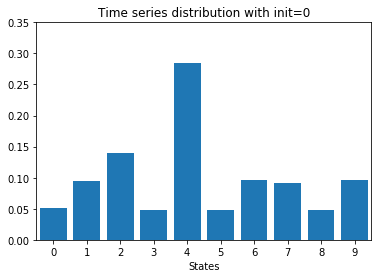

In [71]:
draw_histogram(dist,
               title='Time series distribution with init={0}'.format(init),
               xlabel='States', ylim=(0, 0.35))
plt.show()

Observe that the distribution is close to the (unique) stationary distribution $\pi$.

In [72]:
print(pi)

[0.048 0.095 0.143 0.048 0.286 0.048 0.095 0.095 0.048 0.095]


Next, plot the simulated marginal distributions
at $T = 10d+1, \ldots, 11d, 11d+1, \ldots, 12d$ with initial state `0`:

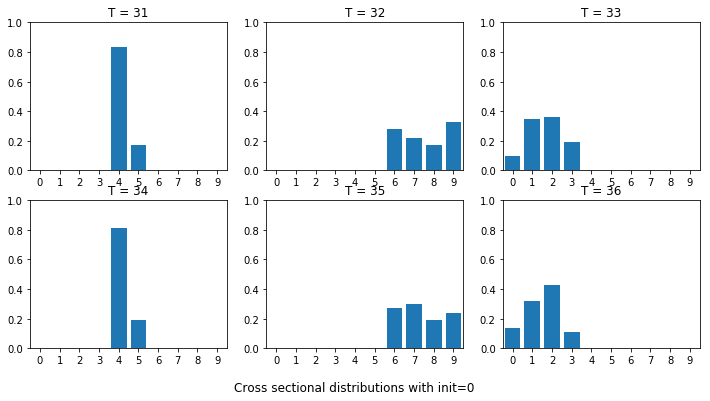

In [73]:
init = 0
k = 10
Ts = [k*d + 1 + i for i in range(2*d)]
num_reps = 10**2
dists = cross_sectional_dist(mc2, T=Ts, init=init, num_reps=num_reps)

fig, axes = plt.subplots(2, d, figsize=(12, 6))
for dist, T, ax in zip(dists, Ts, axes.flatten()):
    draw_histogram(dist, ax=ax,
                   title='T = {T}'.format(T=T))
fig.suptitle('Cross sectional distributions with init={init}'.format(init=init),
             y=0.05, fontsize=12)
plt.show()

Compare these with the rows of $P^{10d+1}, \ldots, P^{10d+d}$.

## Example 3: Nearly completely decomposable chain

Consider the Markov chain given by the following stochastic matrix $P^{\varepsilon}$,
parameterized by $\varepsilon$:

In [74]:
def P_epsilon(eps, p=0.5):
    P = np.array([[1-(p+eps), p,         eps],
                  [p,         1-(p+eps), eps],
                  [eps,       eps,       1-2*eps]])
    return P

If $\varepsilon = 0$,
then the Markovh chain is reducible into two recurrent classes, `[0, 1]` and `[2]`:

In [75]:
P_epsilon(0)

array([[0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0. , 0. , 1. ]])

In [76]:
MarkovChain(P_epsilon(0)).recurrent_classes

[array([0, 1]), array([2])]

If $\varepsilon > 0$ but small, the chain is irreducible,
but transition within each of the subsets `[0, 1]` and `[2]` is much more likely
than that between these sets.

In [77]:
P_epsilon(0.001)

array([[0.499, 0.5  , 0.001],
       [0.5  , 0.499, 0.001],
       [0.001, 0.001, 0.998]])

In [78]:
MarkovChain(P_epsilon(0.001)).recurrent_classes

[array([0, 1, 2])]

Analytically, the unique stationary distribution of the chain with $\varepsilon > 0$
is `(1/3, 1/3, 1/3)`, independent of the value of $\varepsilon$.

However,
for such matrices with small values of $\varepsilon > 0$,
general purpose eigenvalue solvers are numerically unstable.

For example, if we use [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html)
to compute the eigenvector that corresponds
to the dominant (i.e., largest in magnitude) eigenvalue:

In [79]:
np.set_printoptions(precision=15)  # Increase the number of digits printed

In [80]:
epsilons = [float('1e-{i}'.format(i=i)) for i in range(12, 18)]
for eps in epsilons:
    print('epsilon = {eps}'.format(eps=eps))
    w, v = np.linalg.eig(P_epsilon(eps).T)
    i = w.argmax()
    print(v[:, i]/v[:, i].sum())

epsilon = 1e-12
[0.33333662324477  0.33333662324477  0.333326753510459]
epsilon = 1e-13
[0.333344849397111 0.333344849397111 0.333310301205779]
epsilon = 1e-14
[0.333000773366967 0.333000773366967 0.333998453266065]
epsilon = 1e-15
[0.329141015582661 0.329141015582661 0.341717968834677]
epsilon = 1e-16
[0.5 0.5 0. ]
epsilon = 1e-17
[0.5 0.5 0. ]


The output becomes farther from the actual stationary distribution `(1/3, 1/3, 1/3)`
as $\varepsilon$ becomes smaller.

The same applies to [`scipy.linalg.eig`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.htm):

In [81]:
import scipy.linalg

for eps in epsilons:
    print('epsilon = {eps}'.format(eps=eps))
    w, v = scipy.linalg.eig(P_epsilon(eps), left=True, right=False)
    i = w.argmax()
    print(v[:, i]/v[:, i].sum())

epsilon = 1e-12
[0.33333662324477  0.33333662324477  0.333326753510459]
epsilon = 1e-13
[0.333344849397131 0.333344849397131 0.333310301205738]
epsilon = 1e-14
[0.333883550460886 0.333883550460886 0.332232899078228]
epsilon = 1e-15
[0.329141015582661 0.329141015582661 0.341717968834677]
epsilon = 1e-16
[0.344742003948057 0.344742003948057 0.310515992103886]
epsilon = 1e-17
[ 0.523579944426164  0.523579944426163 -0.047159888852327]


`MarkovChain` in `quantecon` employs
the algorithm called the "[GTH algorithm](http://quanteconpy.readthedocs.org/en/stable/markov/gth_solve.html)",
which is a numerically stable variant of Gaussian elimination,
specialized for Markov chains.

In [82]:
for eps in epsilons + [1e-100]:
    print('epsilon = {eps}'.format(eps=eps))
    print(MarkovChain(P_epsilon(eps)).stationary_distributions[0])

epsilon = 1e-12
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-13
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-14
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-15
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-16
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-17
[0.333333333333333 0.333333333333333 0.333333333333333]
epsilon = 1e-100
[0.333333333333333 0.333333333333333 0.333333333333333]


It succeeds in obtaining the correct stationary distribution for any value of $\varepsilon$.